# MEASO space paper


## Loading libraries

In [1]:
%matplotlib inline
import xarray as xr
import pandas as pd
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from dask.distributed import Client, progress
import geopandas
import UsefulFunctions as uf
from clef.code import *
import os

## Setting up

In [2]:
client = Client(n_workers = 12)

In [4]:
db = connect()
s = Session()

## Using clef to check what data is available in ACCESS-ESM 1.5
Currently using conservative water temperature in historical experiment as an example 

In [5]:
constraints = {'variable_id': 'bigthetao', 'model': 'ACCESS-ESM1-5', 'frequency': 'mon', 'experiment_id':'historical'}
df = search(s, project = 'CMIP6', latest = True, **constraints)
df

,project,activity_id,institution_id,source_id,source_type,experiment_id,sub_experiment_id,frequency,realm,variant_label,...,nominal_resolution,table_id,version,variable,path,filename,periods,fdate,tdate,time_complete
path,,,,,,,,,,,,,,,,,,,,,
/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/Omon/bigthetao/gn/v20191115,CMIP6,CMIP,CSIRO,ACCESS-ESM1-5,AOGCM,historical,none,mon,ocean,r1i1p1f1,...,250 km,Omon,v20191115,bigthetao,/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACC...,{bigthetao_Omon_ACCESS-ESM1-5_historical_r1i1p...,"[(18800101, 18891231), (19200101, 19291231), (...",18500101,20141231,True
/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r2i1p1f1/Omon/bigthetao/gn/v20191128,CMIP6,CMIP,CSIRO,ACCESS-ESM1-5,AOGCM,historical,none,mon,ocean,r2i1p1f1,...,250 km,Omon,v20191128,bigthetao,/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACC...,{bigthetao_Omon_ACCESS-ESM1-5_historical_r2i1p...,"[(19200101, 19291231), (18800101, 18891231), (...",18500101,20141231,True
/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r3i1p1f1/Omon/bigthetao/gn/v20191203,CMIP6,CMIP,CSIRO,ACCESS-ESM1-5,AOGCM,historical,none,mon,ocean,r3i1p1f1,...,250 km,Omon,v20191203,bigthetao,/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACC...,{bigthetao_Omon_ACCESS-ESM1-5_historical_r3i1p...,"[(19200101, 19291231), (18800101, 18891231), (...",18500101,20141231,True
/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r9i1p1f1/Omon/bigthetao/gn/v20200529,CMIP6,CMIP,CSIRO,ACCESS-ESM1-5,AOGCM,historical,none,mon,ocean,r9i1p1f1,...,250 km,Omon,v20200529,bigthetao,/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACC...,{bigthetao_Omon_ACCESS-ESM1-5_historical_r9i1p...,"[(19200101, 19291231), (18800101, 18891231), (...",18500101,20141231,True
/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r7i1p1f1/Omon/bigthetao/gn/v20200529,CMIP6,CMIP,CSIRO,ACCESS-ESM1-5,AOGCM,historical,none,mon,ocean,r7i1p1f1,...,250 km,Omon,v20200529,bigthetao,/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACC...,{bigthetao_Omon_ACCESS-ESM1-5_historical_r7i1p...,"[(19200101, 19291231), (18800101, 18891231), (...",18500101,20141231,True
/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r6i1p1f1/Omon/bigthetao/gn/v20200529,CMIP6,CMIP,CSIRO,ACCESS-ESM1-5,AOGCM,historical,none,mon,ocean,r6i1p1f1,...,250 km,Omon,v20200529,bigthetao,/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACC...,{bigthetao_Omon_ACCESS-ESM1-5_historical_r6i1p...,"[(18800101, 18891231), (19200101, 19291231), (...",18500101,20141231,True
/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r4i1p1f1/Omon/bigthetao/gn/v20200529,CMIP6,CMIP,CSIRO,ACCESS-ESM1-5,AOGCM,historical,none,mon,ocean,r4i1p1f1,...,250 km,Omon,v20200529,bigthetao,/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACC...,{bigthetao_Omon_ACCESS-ESM1-5_historical_r4i1p...,"[(18800101, 18891231), (19200101, 19291231), (...",18500101,20141231,True
/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r8i1p1f1/Omon/bigthetao/gn/v20200529,CMIP6,CMIP,CSIRO,ACCESS-ESM1-5,AOGCM,historical,none,mon,ocean,r8i1p1f1,...,250 km,Omon,v20200529,bigthetao,/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACC...,{bigthetao_Omon_ACCESS-ESM1-5_historical_r8i1p...,"[(18800101, 18891231), (19200101, 19291231), (...",18500101,20141231,True
/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r5i1p1f1/Omon/bigthetao/gn/v20200601,CMIP6,CMIP,CSIRO,ACCESS-ESM1-5,AOGCM,historical,none,mon,ocean,r5i1p1f1,...,250 km,Omon,v20200601,bigthetao,/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACC...,{bigthetao_Omon_ACCESS-ESM1-5_historical_r5i1p...,"[(19200101, 19291231), (18800101, 18891231), (...",18500101,20141231,True


In [6]:
constraints = {'variable_id': 'areacello', 'model': 'ACCESS-ESM1-5', 'experiment_id':'historical', 'variant_label':'r1i1p1f1'}
df2 = search(s, project = 'CMIP6', latest = True, **constraints)
df2

,project,activity_id,institution_id,source_id,source_type,experiment_id,sub_experiment_id,frequency,realm,variant_label,...,nominal_resolution,table_id,version,variable,path,filename,periods,fdate,tdate,time_complete
path,,,,,,,,,,,,,,,,,,,,,
/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/Ofx/areacello/gn/v20191115,CMIP6,CMIP,CSIRO,ACCESS-ESM1-5,AOGCM,historical,none,fx,ocean,r1i1p1f1,...,250 km,Ofx,v20191115,areacello,/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACC...,{areacello_Ofx_ACCESS-ESM1-5_historical_r1i1p1...,[],None,None,None


In [36]:
#Checking column names
df.columns

Index(['project', 'activity_id', 'institution_id', 'source_id', 'source_type',
       'experiment_id', 'sub_experiment_id', 'frequency', 'realm',
       'variant_label', 'member_id', 'variable_id', 'grid_label',
       'nominal_resolution', 'table_id', 'version', 'variable', 'path',
       'filename', 'periods', 'fdate', 'tdate', 'time_complete'],
      dtype='object')

## Creating filepaths for the files we are interested in
Currently choosing the first option in the query data frame

In [7]:
path = df['path'][0]
filename = sorted([f[0] for f in zip(df['filename'][0])])
filepath = [os.path.join(path, f) for f in filename]
filepath

['/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/Omon/bigthetao/gn/v20191115/bigthetao_Omon_ACCESS-ESM1-5_historical_r1i1p1f1_gn_185001-185912.nc',
 '/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/Omon/bigthetao/gn/v20191115/bigthetao_Omon_ACCESS-ESM1-5_historical_r1i1p1f1_gn_186001-186912.nc',
 '/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/Omon/bigthetao/gn/v20191115/bigthetao_Omon_ACCESS-ESM1-5_historical_r1i1p1f1_gn_187001-187912.nc',
 '/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/Omon/bigthetao/gn/v20191115/bigthetao_Omon_ACCESS-ESM1-5_historical_r1i1p1f1_gn_188001-188912.nc',
 '/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/Omon/bigthetao/gn/v20191115/bigthetao_Omon_ACCESS-ESM1-5_historical_r1i1p1f1_gn_189001-189912.nc',
 '/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/Omon/bigthetao/gn/v20191115/big

## Checking data prior to further processing
Currently choosing the decade between 2000 and 2010

In [8]:
sst = nc.Dataset(filepath[-2])
print(sst)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Conventions: CF-1.7 CMIP-6.2
    activity_id: CMIP
    branch_method: standard
    branch_time_in_child: 0.0
    branch_time_in_parent: 21915.0
    creation_date: 2019-11-15T15:50:53Z
    data_specs_version: 01.00.30
    experiment: all-forcing simulation of the recent past
    experiment_id: historical
    external_variables: areacello volcello
    forcing_index: 1
    frequency: mon
    further_info_url: https://furtherinfo.es-doc.org/CMIP6.CSIRO.ACCESS-ESM1-5.historical.none.r1i1p1f1
    grid: native atmosphere N96 grid (145x192 latxlon)
    grid_label: gn
    history: 2019-11-15T15:50:53Z ; CMOR rewrote data to be consistent with CMIP6, CF-1.7 CMIP-6.2 and CF standards.
    initialization_index: 1
    institution: Commonwealth Scientific and Industrial Research Organisation, Aspendale, Victoria 3195, Australia
    institution_id: CSIRO
    mip_era: CMIP6
    nominal_resolution: 250 km


In [84]:
print(sst.__dict__)

{'Conventions': 'CF-1.7 CMIP-6.2', 'activity_id': 'CMIP', 'branch_method': 'standard', 'branch_time_in_child': 0.0, 'branch_time_in_parent': 21915.0, 'creation_date': '2019-11-15T15:50:53Z', 'data_specs_version': '01.00.30', 'experiment': 'all-forcing simulation of the recent past', 'experiment_id': 'historical', 'external_variables': 'areacello volcello', 'forcing_index': 1, 'frequency': 'mon', 'further_info_url': 'https://furtherinfo.es-doc.org/CMIP6.CSIRO.ACCESS-ESM1-5.historical.none.r1i1p1f1', 'grid': 'native atmosphere N96 grid (145x192 latxlon)', 'grid_label': 'gn', 'history': '2019-11-15T15:50:53Z ; CMOR rewrote data to be consistent with CMIP6, CF-1.7 CMIP-6.2 and CF standards.', 'initialization_index': 1, 'institution': 'Commonwealth Scientific and Industrial Research Organisation, Aspendale, Victoria 3195, Australia', 'institution_id': 'CSIRO', 'mip_era': 'CMIP6', 'nominal_resolution': '250 km', 'notes': "Exp: ESM-historical; Local ID: HI-05; Variable: bigthetao (['temp'])",

In [87]:
[print(dim) for dim in sst.dimensions.values()]

<class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 120
<class 'netCDF4._netCDF4.Dimension'>: name = 'lev', size = 50
<class 'netCDF4._netCDF4.Dimension'>: name = 'j', size = 300
<class 'netCDF4._netCDF4.Dimension'>: name = 'i', size = 360
<class 'netCDF4._netCDF4.Dimension'>: name = 'bnds', size = 2
<class 'netCDF4._netCDF4.Dimension'>: name = 'vertices', size = 4


[None, None, None, None, None, None]

In [7]:
[print(var) for var in sst.variables.values()]

<class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    bounds: time_bnds
    units: days since 1850-01-01
    calendar: proleptic_gregorian
    axis: T
    long_name: time
    standard_name: time
unlimited dimensions: time
current shape = (120,)
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'netCDF4._netCDF4.Variable'>
float64 time_bnds(time, bnds)
unlimited dimensions: time
current shape = (120, 2)
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'netCDF4._netCDF4.Variable'>
float64 lev(lev)
    bounds: lev_bnds
    units: m
    axis: Z
    positive: down
    long_name: ocean depth coordinate
    standard_name: depth
unlimited dimensions: 
current shape = (50,)
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'netCDF4._netCDF4.Variable'>
float64 lev_bnds(lev, bnds)
unlimited dimensions: 
current shape = (50, 2)
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'netCDF4._netCDF4.Variable'>
int32 j(j)
    

[None, None, None, None, None, None, None, None, None, None, None]

## Loading data
Choosing one decade only, which include the years between 2000 and 2010. Default missing values changed to NAs in the data array

In [9]:
sst = xr.open_dataarray(filepath[-2], mask_and_scale = True, drop_variables = ("time_bnds", "lev_bnds", "vertices_latitude", "vertices_longitude"))
sst

<xarray.DataArray 'bigthetao' (time: 120, lev: 50, j: 300, i: 360)>
[648000000 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 2000-01-16T12:00:00 ... 2009-12-16T12:00:00
  * lev        (lev) float64 5.0 15.0 25.0 ... 5.166e+03 5.499e+03 5.831e+03
  * j          (j) int32 0 1 2 3 4 5 6 7 8 ... 292 293 294 295 296 297 298 299
  * i          (i) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
    latitude   (j, i) float64 ...
    longitude  (j, i) float64 ...
Attributes:
    standard_name:   sea_water_conservative_temperature
    long_name:       Sea Water Conservative Temperature
    comment:         Sea water conservative temperature (this should be contr...
    units:           degC
    original_units:  K
    history:         2019-11-15T15:50:50Z altered by CMOR: Converted units fr...
    cell_methods:    area: mean where sea time: mean
    cell_measures:   area: areacello volume: volcello

### Correcting latitude and longitude dimensions

In [10]:
lon = sst['longitude'][0].values
lon[np.where(lon > 180)] = lon[np.where(lon >180)]-360
sst.coords['i'] = lon
sst.coords['j'] = sst['latitude'][:,0].values
sst = sst.drop(('latitude', 'longitude'))
sst = sst.rename(({'i':'longitude', 'j':'latitude'}))
sst = sst.sortby(sst.longitude)
sst

<xarray.DataArray 'bigthetao' (time: 120, lev: 50, latitude: 300, longitude: 360)>
[648000000 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 2000-01-16T12:00:00 ... 2009-12-16T12:00:00
  * lev        (lev) float64 5.0 15.0 25.0 ... 5.166e+03 5.499e+03 5.831e+03
  * latitude   (latitude) float64 -77.88 -77.63 -77.38 ... 65.21 65.21 65.21
  * longitude  (longitude) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Attributes:
    standard_name:   sea_water_conservative_temperature
    long_name:       Sea Water Conservative Temperature
    comment:         Sea water conservative temperature (this should be contr...
    units:           degC
    original_units:  K
    history:         2019-11-15T15:50:50Z altered by CMOR: Converted units fr...
    cell_methods:    area: mean where sea time: mean
    cell_measures:   area: areacello volume: volcello

### Selecting data for the upper 200 m in the Southern Ocean
Calculating mean water temperature per month within the SO

In [11]:
sst_upper200_SO = sst.sel(lev = slice(0, 201)).sel(latitude = slice(-90, -30)).groupby('time').mean('lev')
sst_upper200_SO

<xarray.DataArray 'bigthetao' (time: 120, latitude: 77, longitude: 360)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [-0.8984221 , -0.8162155 , -0.7291702 , ..., -0.9469787 ,
         -0.9600692 , -0.94371784],
        [-1.1035018 , -1.0968764 , -1.0791366 , ..., -1.1093841 ,
         -1.1064131 , -1.1087477 ],
        ...,
        [17.39877   , 17.1595    , 17.242378  , ..., 19.114103  ,
         18.529434  , 17.859158  ],
        [17.865303  , 17.898182  , 18.04274   , ..., 18.743221  ,
         18.303837  , 17.985016  ],
        [18.571953  , 18.595966  , 18.67326   , ..., 18.654118  ,
         18.487644  , 18.478115  ]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [-0.7460402 , -0.63614345, -0.55434716, ..., -0.8973876 ,
         -0.89770806, -0.83216393],
        [-1.1125747 , -1.0597944 , -0.994609  , ..., -1.1450912 ,
         -1.1521437 , -1.1416488 ],
...
        [16.688292  , 16.401493  , 16.243912  , ..., 17.954449  ,
         17.563093  , 17.108822  ],
        [16.786646  , 16.693647  , 16.720385  , ..., 17.667822  ,
         17.365223  , 17.055813  ],
        [17.185585  , 17.213291  , 17.356493  , ..., 17.469337  ,
         17.294558  , 17.18435   ]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [-1.7215421 , -1.7214873 , -1.7120787 , ..., -1.7136244 ,
         -1.7155058 , -1.7190946 ],
        [-1.7187712 , -1.7199628 , -1.7161818 , ..., -1.7232023 ,
         -1.7196013 , -1.7186582 ],
        ...,
        [17.20037   , 16.956491  , 16.810884  , ..., 18.536491  ,
         18.090942  , 17.614048  ],
        [17.31769   , 17.255552  , 17.314663  , ..., 18.21091   ,
         17.86392   , 17.545244  ],
        [17.77856   , 17.806843  , 17.922934  , ..., 17.984615  ,
         17.825264  , 17.736912  ]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2000-01-16T12:00:00 ... 2009-12-16T12:00:00
  * latitude   (latitude) float64 -77.88 -77.63 -77.38 ... -32.5 -31.5 -30.5
  * longitude  (longitude) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5

### Checking data after processing

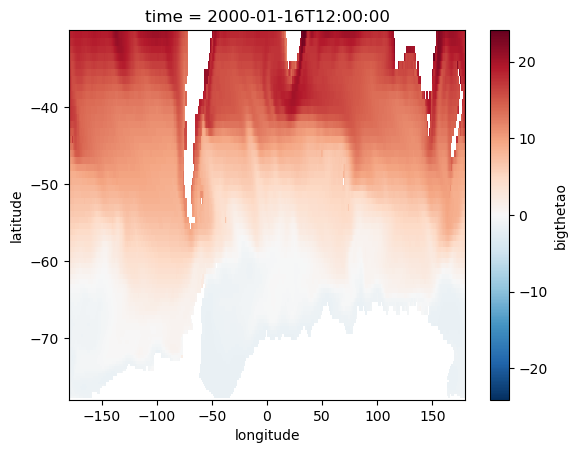

In [12]:
sst_upper200_SO[0].plot()

## Getting area of grid

In [13]:
filename = [f[0] for f in zip(df2['filename'][0])]
filepath = os.path.join(df2['path'][0], filename[0])

In [14]:
area = xr.open_dataarray(filepath, mask_and_scale = True, drop_variables = ("vertices_latitude", "vertices_longitude"))
lon = area['longitude'][0].values
lon[np.where(lon > 180)] = lon[np.where(lon >180)]-360
area.coords['i'] = lon
area.coords['j'] = area['latitude'][:,0].values
area = area.drop(('latitude', 'longitude'))
area = area.rename(({'i':'longitude', 'j':'latitude'}))
area = area.sortby(area.longitude)
area = area.sel(latitude = slice(-90, -30))
area

<xarray.DataArray 'areacello' (latitude: 77, longitude: 360)>
array([[0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [6.554656e+08, 6.554656e+08, 6.554656e+08, ..., 6.554656e+08,
        6.554656e+08, 6.554656e+08],
       [6.717785e+08, 6.717785e+08, 6.717785e+08, ..., 6.717785e+08,
        6.717785e+08, 6.717785e+08],
       ...,
       [1.040771e+10, 1.040771e+10, 1.040771e+10, ..., 1.040771e+10,
        1.040771e+10, 1.040771e+10],
       [1.053489e+10, 1.053489e+10, 1.053489e+10, ..., 1.053489e+10,
        1.053489e+10, 1.053489e+10],
       [1.065262e+10, 1.065262e+10, 1.065262e+10, ..., 1.065262e+10,
        1.065262e+10, 1.065262e+10]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 -77.88 -77.63 -77.38 ... -32.5 -31.5 -30.5
  * longitude  (longitude) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Attributes:
    standard_name:  cell_area
    long_name:      Grid-Cell Area for Ocean Variables
    comment:        Horizontal area of ocean grid cells
    units:          m2
    cell_methods:   area: sum

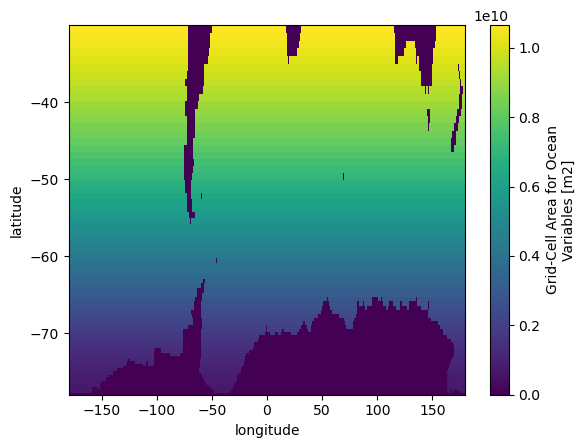

In [15]:
area.plot()

## Loading shapefile with MEASO regions

In [16]:
#Accessing shapefile containing the boundaries being used to clip data. Note that the full file path is being used.
regions = geopandas.read_file(r'/g/data/v45/la6889/GIS_DataBase/Shapefiles/MEASO/measo_wgs84.shp')
regions

,name,sector,zone,fill,geometry
0,WPA,West Pacific,Antarctic,#016074FF,"POLYGON ((-180.00000 -64.70000, -166.00000 -64..."
1,WPA,West Pacific,Antarctic,#BCECFEFF,"POLYGON ((-180.00000 -64.70000, -166.00000 -64..."
2,WPS,West Pacific,Subantarctic,#1094AFFF,"POLYGON ((-125.00000 -65.20000, -128.00000 -65..."
3,WPN,West Pacific,Northern,#054e70FF,"POLYGON ((-125.00000 -40.00000, -125.00000 -56..."
4,WPT,West Pacific,Temperate,None,"POLYGON ((-125.00000 -30.00000, -125.00000 -40..."
5,EPA,East Pacific,Antarctic,#FFFFFFFF,"POLYGON ((-125.00000 -85.00000, -125.00000 -65..."
6,EPS,East Pacific,Subantarctic,#5F9EA0FF,"POLYGON ((-125.00000 -65.20000, -125.00000 -56..."
7,EPN,East Pacific,Northern,#4B7D7EFF,"POLYGON ((-125.00000 -56.80000, -125.00000 -40..."
8,EPT,East Pacific,Temperate,None,"POLYGON ((-125.00000 -40.00000, -125.00000 -30..."
9,AOA,Atlantic,Antarctic,#BCECFEFF,"POLYGON ((-59.00000 -59.40791, -59.00000 -58.6..."


### Checking MEASO regions and data are correctly aligned

<AxesSubplot:title={'center':'time = 2000-01-16T12:00:00'}, xlabel='longitude', ylabel='latitude'>

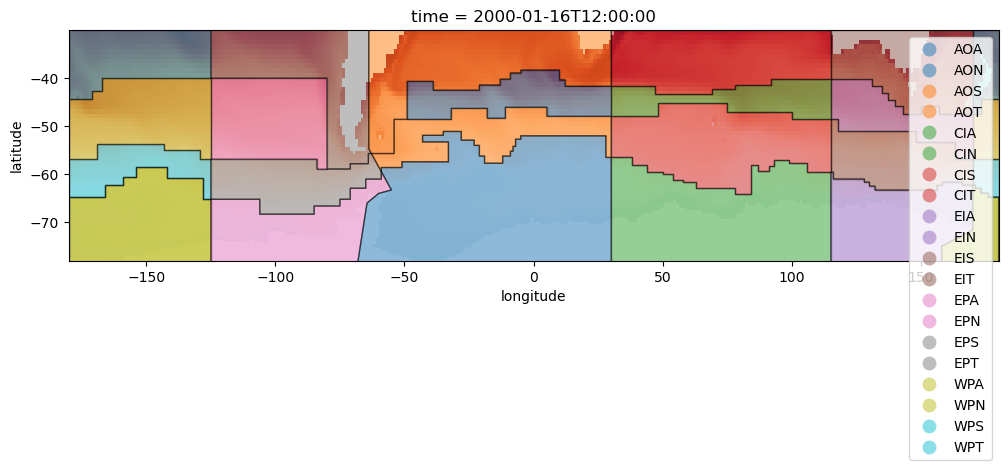

In [17]:
# Plot shapefile over the raster to ensure they both have the same CRS and cover the same area
#Initialise figure
fig, ax = plt.subplots(figsize = (12, 15))

#Plot just one timestep of the data array
sst_upper200_SO[0].plot(ax = ax, add_colorbar = False)

#Plot shapefile over the top and show each sector in different colour
regions.plot(ax = ax, column = 'name', legend = True, alpha = 0.5, edgecolor = 'black')

## Extracting data per MEASO region

In [18]:
regionNames = sorted(set(regions.name.values))
regionNames

['AOA',
 'AON',
 'AOS',
 'AOT',
 'CIA',
 'CIN',
 'CIS',
 'CIT',
 'EIA',
 'EIN',
 'EIS',
 'EIT',
 'EPA',
 'EPN',
 'EPS',
 'EPT',
 'WPA',
 'WPN',
 'WPS',
 'WPT']

In [19]:
#Subsetting shapefiles into regions - Initialise dictionary that will contain sector limits
MEASOregions = {}

#Saving each sector as an entry in the dictionary
for i in regionNames:
    MEASOregions[f"{i}"] = regions.query(f'name == "{i}"')

In [20]:
#Subsetting shapefiles into sectors - Initialise dictionary that will contain sector limits
clipped_varInt = {}
clipped_area = {}

#Saving each sector as an entry in the dictionary
for i in regionNames:
    clipped_varInt[f"{i}"] = uf.clipDataArray(sst_upper200_SO, shp = MEASOregions[i])
    clipped_area[f"{i}"] = uf.clipDataArray(area, shp = MEASOregions[i])

### Checking results of extraction

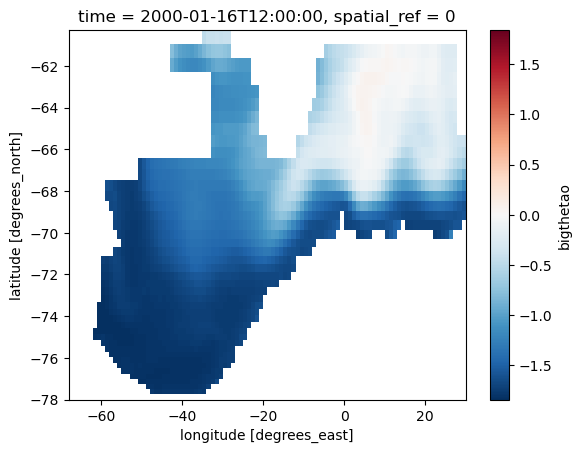

In [21]:
clipped_varInt['AOA'][0].plot()

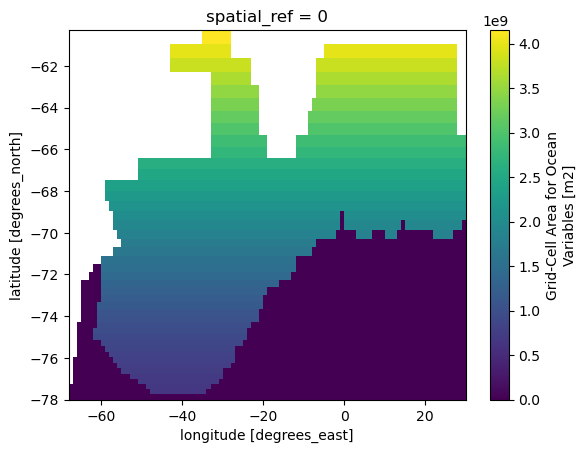

In [22]:
clipped_area['AOA'].plot()

## Calculating weighted means

In [33]:
#Getting a list of the years included in the data
years = sst_upper200_SO.indexes['time'].year

#Loop through all sectors
for region in regionNames:
    #Slice data per year and calculate seasonal weighted means
    for yr in years:
        x = uf.weightedMeans(clipped_varInt[region].sel(time = str(yr)), clipped_area[region], meanby = 'month')
        #Add time dimension containing the year for which calculations are done
        x = uf.addTimeYear(x, yr, by = 'month')
        #Save netcdf file
        x.to_netcdf('YearlyMonthlyMeans_' + region + 'region_2000-2009.nc')
    #Remove unused variables
    del x

#Remove unused variables
del years

In [36]:
xr.open_dataarray('YearlyMonthlyMeans_WPNregion_2000-2009.nc')

<xarray.DataArray (month: 12)>
array([6.122052, 6.522734, 6.63957 , 6.382081, 6.104219, 5.707814, 5.344544,
       4.997611, 4.780879, 4.824975, 5.062714, 5.429814], dtype=float32)
Coordinates:
    spatial_ref  int64 ...
  * month        (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
    time         (month) object ...